In [126]:
# Detecting Fraud Transactions for "IndAvenue" Payment Gateway Startup

In [1]:
# Importing Libraries 

import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
!pip install imblearn

In [4]:
os.getcwd()

'C:\\Users\\SAI VIVEK.K\\MITH_Exam_Sep'

In [5]:
os.chdir('C:\\Users\\SAI VIVEK.K\\MITH_Exam_Sep')

In [6]:
# Reading and Importing the Dataset
Indav_train = pd.read_csv('train_data-1599717478076.csv')
Indav_test  = pd.read_csv('test_data-1599717650029.csv')

In [7]:
# Exploratory Data Analysis and Preprocessing

# 1) Identification of Varibales and Datatypes

In [8]:
Indav_train.dtypes

transaction_number            int64
user_id                       int64
payment_method               object
partner_id                    int64
partner_category             object
country                      object
device_type                  object
money_transacted            float64
transaction_initiation       object
partner_pricing_category      int64
is_fraud                      int64
dtype: object

In [9]:
print(Indav_train.shape)
print(Indav_test.shape)

(76529, 11)
(19133, 10)


In [10]:
Indav_train.head()

,transaction_number,user_id,payment_method,partner_id,partner_category,country,device_type,money_transacted,transaction_initiation,partner_pricing_category,is_fraud
0,144703125000,17539344,sbi_atm_cum_debit_card,47334,cat_1,IND_INR,android_devices,-5.0,2016-11-15 19:16:12+00:00,2,0
1,77406814453032,24710841,e_wallet_payments,78890,cat_2,IND_INR,other_pcs,100.0,2017-01-11 09:25:33+00:00,2,0
2,308929485482801,24265476,e_wallet_payments,78890,cat_2,IND_INR,other_pcs,50.0,2016-12-07 07:58:09+00:00,2,0
3,665270027747073,10240000,other_debit_cards,102557,cat_3,IND_INR,other_pcs,1000.0,2017-01-11 16:15:44+00:00,2,0
4,38276160171101,5880625,other_debit_cards,118335,cat_1,IND_INR,other_pcs,200.0,2016-11-16 17:04:42+00:00,2,0


In [11]:
# Summary Statistics and Distribution of the Numeric Columns

Indav_train.describe()

,transaction_number,user_id,partner_id,money_transacted,partner_pricing_category,is_fraud
count,7.652900e+04,7.652900e+04,76529.000000,76529.000000,76529.000000,76529.000000
mean,6.940200e+14,1.247483e+07,58497.189105,132.724348,2.255707,0.002012
std,7.867885e+14,1.205878e+07,36740.216787,2350.110900,0.732174,0.044814
min,8.000000e+00,1.000000e+00,7889.000000,-20000.000000,0.000000,0.000000
25%,4.387866e+13,3.515625e+06,23667.000000,-1.000000,2.000000,0.000000
50%,3.452540e+14,9.753129e+06,47334.000000,20.000000,2.000000,0.000000
75%,1.173440e+15,1.788444e+07,78890.000000,52.000000,2.000000,0.000000
max,2.784238e+15,5.592048e+07,213003.000000,197217.760000,4.000000,1.000000


In [12]:
Indav_train.describe(include = 'object')

,payment_method,partner_category,country,device_type,transaction_initiation
count,76529,76529,76529,76529,76529
unique,6,9,1,4,75811
top,sbi_atm_cum_debit_card,cat_1,IND_INR,other_pcs,2016-12-24 16:30:13+00:00
freq,30538,36306,76529,45560,12


In [13]:
# 2) Non - Graphical Univariate Analysis
#Distribution of dependent variable

In [14]:
Indav_train.is_fraud.value_counts(normalize = True)*100

0    99.798769
1     0.201231
Name: is_fraud, dtype: float64

In [15]:
# number of fraud and non-fraud observations in the dataset
frauds = len(Indav_train[Indav_train.is_fraud == 1])
nonfrauds = len(Indav_train[Indav_train.is_fraud == 0])
print("Frauds", frauds); print("Non-frauds", nonfrauds)

Frauds 154
Non-frauds 76375


In [17]:
Indav_train[Indav_train.is_fraud == 1].device_type.value_counts(normalize=True)*100

other_pcs          94.155844
android_devices     3.246753
windows_pcs         2.597403
Name: device_type, dtype: float64

In [18]:
Indav_train[Indav_train.is_fraud == 1].payment_method.value_counts(normalize=True)*100

visa_master_credit_cards    34.415584
visa_master_debit_cards     33.116883
other_debit_cards           27.922078
sbi_atm_cum_debit_card       3.246753
e_wallet_payments            1.298701
Name: payment_method, dtype: float64

In [19]:
Indav_train[Indav_train.is_fraud == 1].partner_category.value_counts(normalize=True)*100

cat_1    83.116883
cat_2     9.740260
cat_3     5.844156
cat_8     1.298701
Name: partner_category, dtype: float64

In [20]:
pd.set_option('display.max_rows', None)

In [16]:
# Findind Null Values in the Dataframe

Indav_train.isnull().sum()

transaction_number          0
user_id                     0
payment_method              0
partner_id                  0
partner_category            0
country                     0
device_type                 0
money_transacted            0
transaction_initiation      0
partner_pricing_category    0
is_fraud                    0
dtype: int64

In [21]:
Indav_train.groupby(['payment_method','is_fraud']).mean()

transaction_number       user_id  \
payment_method             is_fraud                                     
e_wallet_payments          0               6.999774e+14  1.001647e+07   
                           1               1.552691e+15  1.454935e+07   
other_debit_cards          0               6.918884e+14  7.227493e+06   
                           1               7.439220e+14  1.255718e+07   
sbi_atm_cum_debit_card     0               6.907741e+14  1.544615e+07   
                           1               7.290795e+14  4.368698e+07   
unified_payments_interface 0               2.273071e+14  8.097947e+06   
visa_master_credit_cards   0               7.190766e+14  1.044030e+07   
                           1               6.839743e+14  6.567922e+06   
visa_master_debit_cards    0               6.841605e+14  1.289803e+07   
                           1               7.547601e+14  1.535044e+07   

                                        partner_id  money_transacted  \
payment_method             is_fraud                                    
e_wallet_payments          0          51300.972500         73.685087   
                           1          51278.500000      11000.000000   
other_debit_cards          0          95697.539308        379.458711   
                           1         112831.046512      47146.919070   
sbi_atm_cum_debit_card     0          47713.554613        -76.264637   
                           1          39445.000000      -9604.020000   
unified_payments_interface 0          61008.266667         29.200000   
visa_master_credit_cards   0          83154.857143        496.783449   
                           1         120418.886792      17890.063396   
visa_master_debit_cards    0          83817.222222        256.040267   
                           1         106114.784314      32708.822353   

                                     partner_pricing_category  
payment_method             is_fraud                            
e_wallet_payments          0                         1.997224  
                           1                         2.000000  
other_debit_cards          0                         2.663971  
                           1                         1.488372  
sbi_atm_cum_debit_card     0                         2.279828  
                           1                         2.800000  
unified_payments_interface 0                         2.000000  
visa_master_credit_cards   0                         1.345689  
                           1                         1.471698  
visa_master_debit_cards    0                         2.842133  
                           1                         2.000000

In [22]:
Indav_train.groupby(['money_transacted','is_fraud']).mean()

,,transaction_number,user_id,partner_id,partner_pricing_category
money_transacted,is_fraud,,,,
-20000.0000,0,3.689278e+13,5.384624e+07,23667.000000,4.000000
-18000.0000,1,1.847450e+14,5.386092e+07,23667.000000,4.000000
-10000.0000,1,1.030555e+15,5.460859e+07,42074.666667,2.666667
-4000.0000,0,1.120665e+15,5.459052e+07,63112.000000,4.000000
-3200.0000,0,6.548766e+11,5.391965e+07,23667.000000,4.000000
-3000.0000,0,4.428578e+14,5.389396e+07,78890.000000,3.000000
-2300.0000,0,1.018767e+14,1.506362e+07,55223.000000,2.000000
-2200.0000,0,1.871336e+13,5.391965e+07,23667.000000,4.000000
-2000.0000,0,4.869853e+14,5.409415e+07,42782.653846,4.000000


In [23]:
#3) Graphical Univariate Analysis
#Plot the Distribution

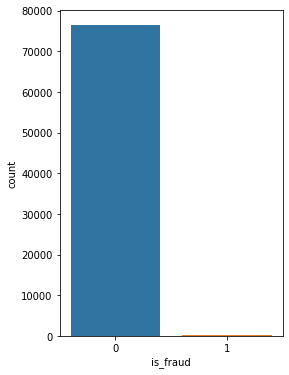

0    76375
1      154
Name: is_fraud, dtype: int64

In [24]:
plt.figure(figsize=(4,6))
sns.countplot(x="is_fraud", data= Indav_train)
plt.show()

Indav_train.is_fraud.value_counts()

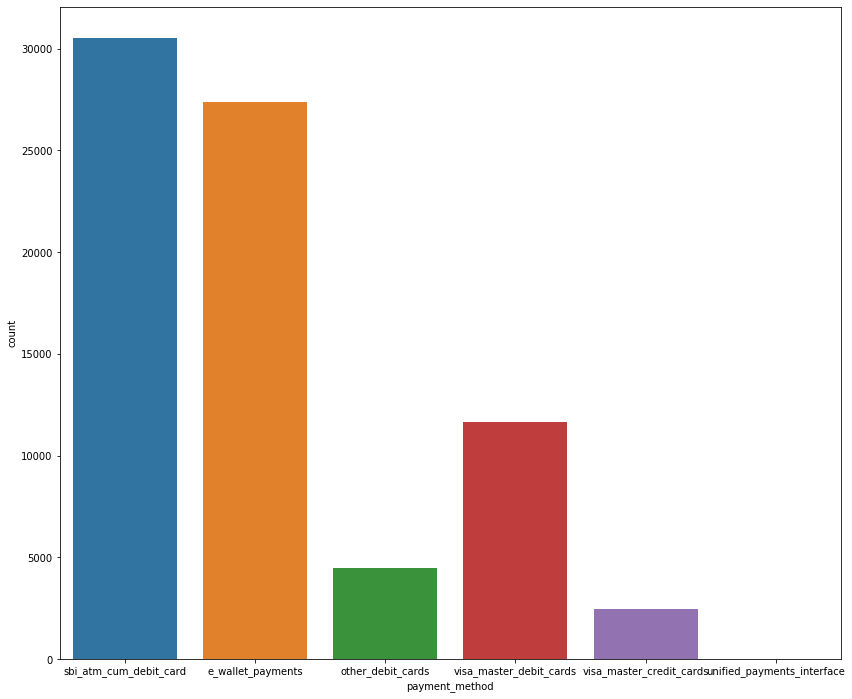

sbi_atm_cum_debit_card        30538
e_wallet_payments             27384
visa_master_debit_cards       11643
other_debit_cards              4495
visa_master_credit_cards       2454
unified_payments_interface       15
Name: payment_method, dtype: int64

In [25]:
plt.figure(figsize=(14,12))
sns.countplot(x="payment_method", data= Indav_train)
plt.show()

Indav_train.payment_method.value_counts()

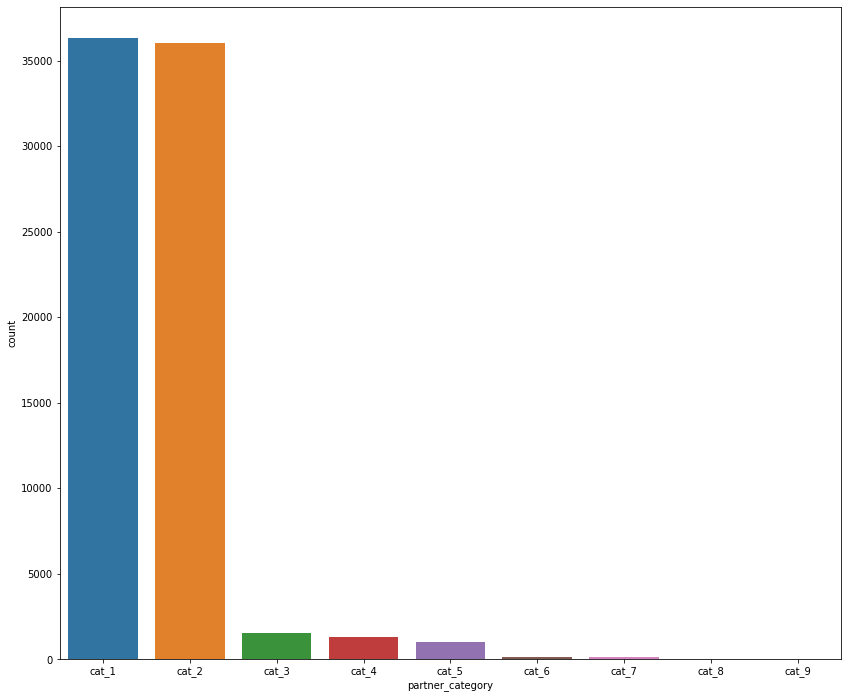

cat_1    36306
cat_2    36019
cat_3     1536
cat_4     1310
cat_5     1026
cat_7      165
cat_6      146
cat_8       19
cat_9        2
Name: partner_category, dtype: int64

In [26]:
plt.figure(figsize=(14,12))
sns.countplot(x="partner_category", data= Indav_train)
plt.show()

Indav_train.partner_category.value_counts()

In [28]:
categorical_columns = [cname for cname in Indav_train.columns if Indav_train[cname].dtype == 'object']

numerical_columns   = [cname for cname in Indav_train.columns if Indav_train[cname].dtype in['int64', 'float64']]

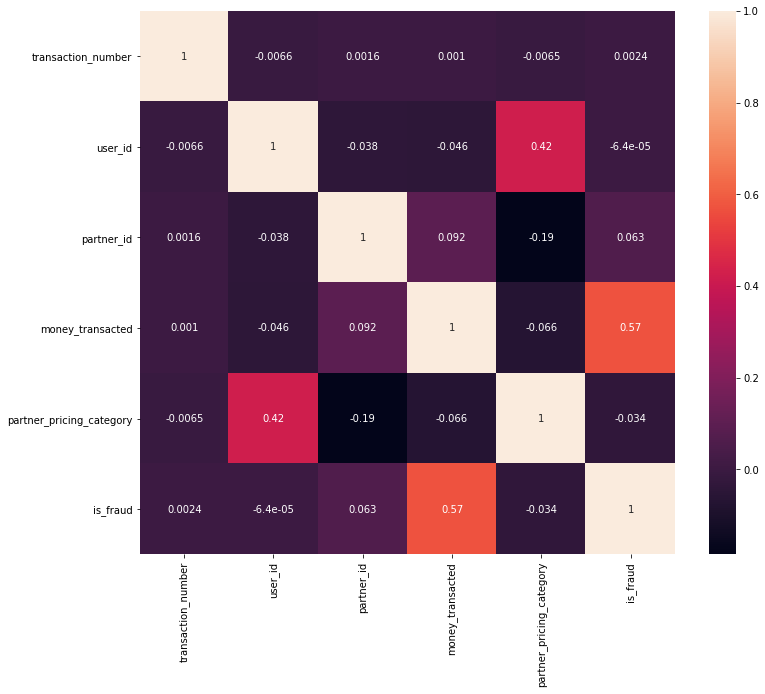

In [29]:
plt.figure(figsize=(12,10))
data = Indav_train[numerical_columns]

df = pd.DataFrame(data)

corrMatrix = df.corr(method = 'pearson',min_periods = 1)
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [30]:
# Feature Engineering

In [31]:
#Dropping Unnecessary Columns
Indav_train.drop("partner_id", axis = 1, inplace= True)
Indav_test.drop("partner_id", axis = 1, inplace= True)

In [32]:
#Type Casting

col = ['payment_method', 'partner_category','country','device_type','is_fraud']
Indav_train[col] = Indav_train[col].astype('category')

In [33]:
Indav_train['money_transacted'] = Indav_train['money_transacted'].astype('int64')
Indav_test['money_transacted'] = Indav_test['money_transacted'].astype('int64')

In [34]:
Indav_train['transaction_initiation'] = pd.to_datetime(Indav_train['transaction_initiation']).dt.year
Indav_test['transaction_initiation'] = pd.to_datetime(Indav_test['transaction_initiation']).dt.year

In [35]:
Indav_train.dtypes

transaction_number             int64
user_id                        int64
payment_method              category
partner_category            category
country                     category
device_type                 category
money_transacted               int64
transaction_initiation         int64
partner_pricing_category       int64
is_fraud                    category
dtype: object

In [36]:
Indav_train.head()

,transaction_number,user_id,payment_method,partner_category,country,device_type,money_transacted,transaction_initiation,partner_pricing_category,is_fraud
0,144703125000,17539344,sbi_atm_cum_debit_card,cat_1,IND_INR,android_devices,-5,2016,2,0
1,77406814453032,24710841,e_wallet_payments,cat_2,IND_INR,other_pcs,100,2017,2,0
2,308929485482801,24265476,e_wallet_payments,cat_2,IND_INR,other_pcs,50,2016,2,0
3,665270027747073,10240000,other_debit_cards,cat_3,IND_INR,other_pcs,1000,2017,2,0
4,38276160171101,5880625,other_debit_cards,cat_1,IND_INR,other_pcs,200,2016,2,0


In [37]:
print(Indav_train.shape)
print(Indav_test.shape)

(76529, 10)
(19133, 9)


In [38]:
#Split Numeric and Categorical Columns

In [39]:
cat_attr = list(Indav_train.select_dtypes("category").columns)
num_attr = list(Indav_train.columns.difference(cat_attr))

In [40]:
cat_attr.pop()

'is_fraud'

In [41]:
cat_attr

['payment_method', 'partner_category', 'country', 'device_type']

In [42]:
num_attr

['money_transacted',
 'partner_pricing_category',
 'transaction_initiation',
 'transaction_number',
 'user_id']

In [62]:
cols_to_use = cat_attr + num_attr

In [43]:
#Instantiate Pre-processing Objects for Pipeline

In [44]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)])

In [45]:
# Undersampling for handling Class imbalance

In [46]:
#Number of samples which are Fraud
no_frauds = len(Indav_train[Indav_train['is_fraud'] == 1])

In [47]:
# indices of non fraud samples
non_fraud_indices = Indav_train[Indav_train.is_fraud == 0].index

In [48]:
#Random sample non fraud indices
random_indices = np.random.choice(non_fraud_indices,no_frauds, replace=False)

In [49]:
fraud_indices = Indav_train[Indav_train.is_fraud == 1].index

In [51]:
#Concat fraud indices with sample non-fraud ones
under_sample_indices = np.concatenate([fraud_indices,random_indices])

In [52]:
#Get Balance Dataframe
under_sample = Indav_train.loc[under_sample_indices]

In [53]:
#Train_Test_Split
X_under = under_sample.loc[:,under_sample.columns != 'is_fraud']
y_under = under_sample.loc[:,under_sample.columns == 'is_fraud']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under,y_under,test_size = 0.3, random_state = 0)

In [54]:
print('X_train dimensions: ', X_under_train.shape)
print('y_train dimensions: ', y_under_train.shape)
print('X_test dimensions:  ', X_under_test.shape)
print('y_test dimensions:  ', y_under_test.shape)

X_train dimensions:  (215, 9)
y_train dimensions:  (215, 1)
X_test dimensions:   (93, 9)
y_test dimensions:   (93, 1)


In [55]:
y_under_train.is_fraud.value_counts()

0    109
1    106
Name: is_fraud, dtype: int64

In [56]:
# Model Building

In [83]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

In [124]:
# Build a Logistic Regression Model

In [58]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

In [59]:
%%time
clf_logreg.fit(X_under_train, y_under_train)

Wall time: 22.9 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['money_transacted',
                                                   'partner_pricing_category',
                                                   'transaction_initiation',
                                                   'transaction_number',
                                                   'user_id']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                  

In [60]:
train_pred = clf_logreg.predict(X_under_train)
test_pred = clf_logreg.predict(X_under_test)

print(clf_logreg.score(X_under_train, y_under_train))
print(clf_logreg.score(X_under_test, y_under_test))
print("\n")
print(confusion_matrix(y_true= y_under_train, y_pred = train_pred))

confusion_matrix_test = confusion_matrix(y_true=y_under_test, y_pred =  test_pred)
confusion_matrix_test

0.9488372093023256
0.9354838709677419


[[104   5]
 [  6 100]]


array([[44,  1],
       [ 5, 43]], dtype=int64)

In [61]:
f1_score(y_true = y_under_test, y_pred = test_pred)

0.9347826086956522

In [125]:
# Build a Random Forest Model

In [67]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

In [68]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)

param_grid = {"classifier__n_estimators" : [150, 250, 300],
              "classifier__max_depth" : [5,8,10],
              "classifier__max_features" : [3, 5, 7],
              "classifier__min_samples_leaf" : [4, 6, 8, 10]}

rf_grid = GridSearchCV(clf, param_grid= param_grid, cv=kfold,verbose=1,n_jobs=6)

In [70]:
%%time
rf_grid.fit(X_under_train,y_under_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   18.4s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   41.8s
[Parallel(n_jobs=6)]: Done 540 out of 540 | elapsed:   51.9s finished


Wall time: 52.4 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=143, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['money_transacted',
                                                                          'partner_pricing_category',
                                                                          'transaction_initiation',
                                                      

In [72]:
rf_grid.best_params_

{'classifier__max_depth': 5,
 'classifier__max_features': 3,
 'classifier__min_samples_leaf': 4,
 'classifier__n_estimators': 150}

In [117]:
Final_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators = 10,
                                     max_features = 'sqrt',
                                     min_samples_leaf = 5,
                                     bootstrap = True,
                                     max_depth = 25,
                                     min_samples_split = 10))])

In [118]:
%%time
Final_rf.fit(X_under_train, y_under_train)

Wall time: 29.9 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['money_transacted',
                                                   'partner_pricing_category',
                                                   'transaction_initiation',
                                                   'transaction_number',
                                                   'user_id']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                  

In [119]:
train_pred = Final_rf.predict(X_under_train)
test_pred = Final_rf.predict(X_under_test)

print(Final_rf.score(X_under_train, y_under_train))
print(Final_rf.score(X_under_test, y_under_test))
print("\n")
print(confusion_matrix(y_true= y_under_train, y_pred = train_pred))

confusion_matrix_test = confusion_matrix(y_true=y_under_test, y_pred =  test_pred)
confusion_matrix_test

0.9906976744186047
0.967741935483871


[[109   0]
 [  2 104]]


array([[45,  0],
       [ 3, 45]], dtype=int64)

In [120]:
f1_score(y_true = y_under_test, y_pred = test_pred)

0.967741935483871

In [121]:
Final_X_test = Indav_test[cols_to_use]
#
test_pred = gbm_grid.predict(Final_X_test)

In [122]:
test_pred[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [123]:
submissions_df = pd.DataFrame({'transaction_number': Indav_test.transaction_number, 'is_fraud': test_pred})
submissions_df.to_csv("final_predictions.csv", index=None)
submissions_df.head()

,transaction_number,is_fraud
0,857050141038272,0
1,4400462872603,0
2,1207915598569499,0
3,2009725616777536,0
4,2319205210274863,0
